# Sheet 6
## 3 Heteroscedastic regression

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from copy import deepcopy

In [ ]:
# Load CSV (assumes columns 'x' and 'y')
df = pd.read_csv("data/x_y.csv")
X = df["x"].values.astype(np.float32).reshape(-1,1)
Y = df["y"].values.astype(np.float32).reshape(-1,1)

# split 66% train / 34% test (use 0.66 train_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.66, random_state=42, shuffle=True
)

# to torch tensors
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_test_t  = torch.from_numpy(X_test)
y_test_t  = torch.from_numpy(y_test)


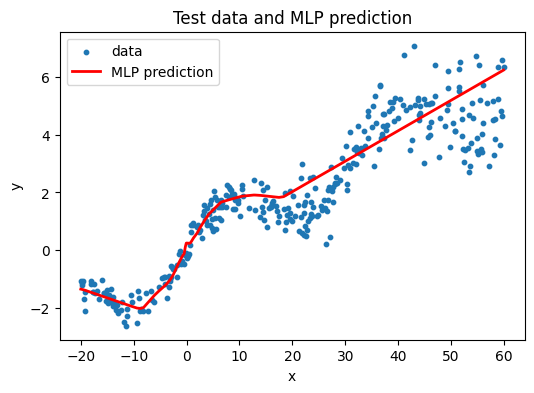

In [3]:
# (re)use X_train_t, y_train_t, X_test_t, y_test_t from (a)

class MLP(nn.Module):
    def __init__(self, in_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Data loaders (small dataset; simple batching)
train_ds = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)

# Training
n_epochs = 600
train_losses = []
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    for xb,yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.shape[0]
    epoch_loss /= len(train_ds)
    train_losses.append(epoch_loss)

# Evaluate on test set and plot
model.eval()
with torch.no_grad():
    X_test_device = X_test_t.to(device)
    y_pred_test = model(X_test_device).cpu().numpy()
    y_test_np = y_test_t.numpy()

# Plot
plt.figure(figsize=(6,4))
plt.scatter(X_test, y_test_np, s=10, label="data")
# sort for nice line plot
ix = np.argsort(X_test.reshape(-1))
plt.plot(X_test[ix], y_pred_test[ix], color="red", linewidth=2, label="MLP prediction")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test data and MLP prediction")
plt.show()


The MLP underfits the data, especially in the region of higher x.

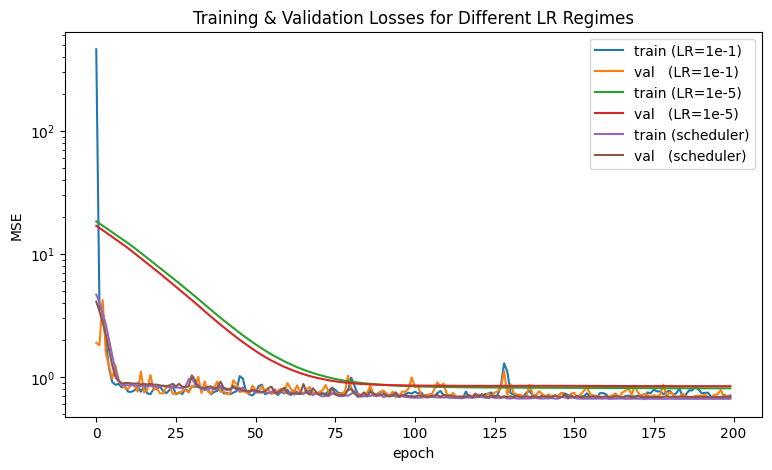

In [15]:
# ----------------------------
# Training function
# ----------------------------
def train_model(model, optimizer, scheduler=None, n_epochs=200):
    # model = deepcopy(model).to(device)
    
    train_losses = []
    val_losses   = []

    val_ds     = torch.utils.data.TensorDataset(X_test_t, y_test_t)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=256, shuffle=False)

    for epoch in range(n_epochs):

        # ---- Training ----
        model.train()
        total_train_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            pred  = model(xb)
            loss  = criterion(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * xb.size(0)

        if scheduler is not None:
            scheduler.step()

        # ---- Evaluation ----
        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                total_val_loss += criterion(model(xb), yb).item() * xb.size(0)

        train_losses.append(total_train_loss / len(train_ds))
        val_losses.append(total_val_loss / len(val_ds))

    return model, train_losses, val_losses


# ----------------------------
# Scheduler: warmup + cosine annealing
# ----------------------------
def get_scheduler(optimizer, n_epochs=200, warmup=30):
    from torch.optim.lr_scheduler import LambdaLR

    def lr_lambda(epoch):
        # linear warmup from very small LR → base LR
        if epoch < warmup:
            return (epoch + 1) / warmup
        
        # cosine decay from base LR → 1% of base LR
        t = (epoch - warmup) / max(1, n_epochs - warmup - 1)
        cosine = 0.5 * (1 + np.cos(np.pi * t))
        return 0.01 + 0.99 * cosine   # ensure LR never reaches 0

    return LambdaLR(optimizer, lr_lambda)


# ----------------------------
# Run experiments
# ----------------------------

# 1) Learning rate too big
model_bigLR = MLP()
opt_bigLR   = optim.Adam(model_bigLR.parameters(), lr=1e-1)
m0, t0, v0  = train_model(model_bigLR, opt_bigLR, n_epochs=200)

# 2) Learning rate too small
model_smallLR = MLP()
opt_smallLR   = optim.Adam(model_smallLR.parameters(), lr=1e-5)
m1, t1, v1    = train_model(model_smallLR, opt_smallLR, n_epochs=200)

# 3) Learning rate scheduler
model_sched = MLP()
base_lr = 1e-3
opt2    = optim.Adam(model_sched.parameters(), lr=base_lr)
sch2    = get_scheduler(opt2, n_epochs=200, warmup=30)
m2, t2, v2 = train_model(model_sched, opt2, scheduler=sch2, n_epochs=200)

# ----------------------------
# Plot results
# ----------------------------
plt.figure(figsize=(9,5))
plt.plot(t0, label="train (LR=1e-1)")
plt.plot(v0, label="val   (LR=1e-1)")
plt.plot(t1, label="train (LR=1e-5)")
plt.plot(v1, label="val   (LR=1e-5)")
plt.plot(t2, label="train (scheduler)")
plt.plot(v2, label="val   (scheduler)")
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training & Validation Losses for Different LR Regimes")
plt.show()


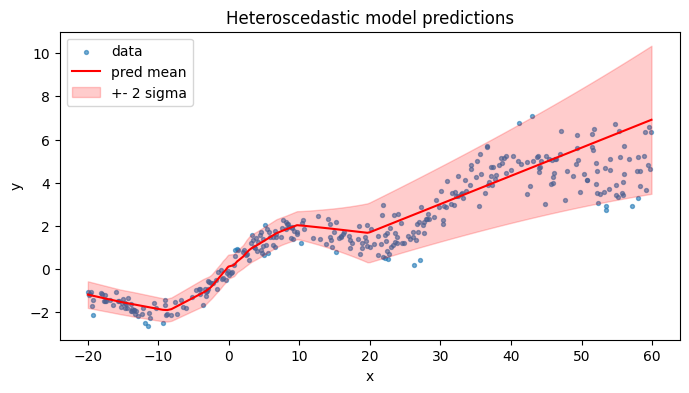

In [16]:
class MLP_Hetero(nn.Module):
    def __init__(self, in_dim=1):
        super().__init__()
        # shared trunk
        self.trunk = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU()
        )
        # two heads: mean and log-variance
        self.mean_head = nn.Linear(64, 1)
        self.logvar_head = nn.Linear(64, 1)  # output s(x) = log sigma^2

    def forward(self, x):
        h = self.trunk(x)
        mu = self.mean_head(h)
        s  = self.logvar_head(h)  # raw log-variance
        return mu, s

def hetero_nll(mu, logvar, y):
    # mu, logvar, y are tensors
    # returns mean loss (not summed)
    inv_var = torch.exp(-logvar)
    # 0.5 * (logvar + (y-mu)^2 * inv_var)  (drop constant)
    loss = 0.5 * (logvar + (y - mu)**2 * inv_var)
    return loss.mean()

# create model, optimizer
model_h = MLP_Hetero().to(device)
opt_h = optim.Adam(model_h.parameters(), lr=1e-3)

# training
n_epochs = 600
hist = []
for epoch in range(n_epochs):
    model_h.train()
    tot = 0.0
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        mu, logvar = model_h(xb)
        loss = hetero_nll(mu, logvar, yb)
        opt_h.zero_grad()
        loss.backward()
        opt_h.step()
        tot += loss.item() * xb.size(0)
    tot /= len(train_ds)
    hist.append(tot)

# evaluate and plot mean and variance predictions
model_h.eval()
with torch.no_grad():
    mu_test, logvar_test = model_h(X_test_t.to(device))
    mu_test = mu_test.cpu().numpy().reshape(-1)
    sigma_test = np.sqrt(np.exp(logvar_test.cpu().numpy().reshape(-1)))
    x_test_np = X_test.reshape(-1)

# sort for plotting
order = np.argsort(x_test_np)
plt.figure(figsize=(8,4))
plt.scatter(x_test_np, y_test.reshape(-1), s=8, alpha=0.6, label='data')
plt.plot(x_test_np[order], mu_test[order], color='red', label='pred mean')
# plot mean +/- 2 sigma
upper = mu_test + 2*sigma_test
lower = mu_test - 2*sigma_test
plt.fill_between(x_test_np[order], lower[order], upper[order], color='red', alpha=0.2, label='+- 2 sigma')
plt.legend()
plt.xlabel('x'); plt.ylabel('y'); plt.title('Heteroscedastic model predictions')
plt.show()


This still looks like a bit of an underfitting for higher x.